In [1]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser
import pickle
import h5py

# Required neural network libraries
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

# Plotting and stuffs (which probably won't work due to X11 issues)
import matplotlib.pylab as plt
import sys

# d-script imports
sys.path.append('..')
import data_iters
from data_iters.hdf5_iterator import Hdf5MiniBatcher
from data_iters.archive.iam_iterator import IAM_MiniBatcher
from data_iters.minibatcher import MiniBatcher

# Denoising stuff
from data_iters.CoffeeStainer import *
from data_iters.NoiseAdder import *

%pdb off

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is disabled)

Automatic pdb calling has been turned OFF


### Define which dataset we'd like to use

In [2]:
# Which training dataset do we want to train from?
train_dataset='iam-words'
noise_dataset='noise'

# All the images that you require extraction should be in this HDF5 file
if train_dataset=='nmec':
    hdf5authors='/fileserver/nmec-handwriting/nmec_scaled_author_form.hdf5'
    hdf5images='nmecdata/nmec_scaled_flat.hdf5'
elif train_dataset=='nmec-bin':
    hdf5authors='nmecdata/author_nmec_bin_uint8.hdf5'
    hdf5images='nmecdata/flat_nmec_bin_uint8.hdf5'
elif train_dataset=='iam-words':
    hdf5authors='/fileserver/iam/iam-processed/words/author_words.hdf5'
elif train_dataset=='iam-binwords':
    hdf5authors='/fileserver/iam/iam-binary/iam_author_words_bin.hdf5'
    hdf5images='/fileserver/iam/iam-binary/iam_flat_words_bin.hdf5'
elif train_dataset=='iam-lines':
    hdf5authors='/fileserver/iam/iam-processed/lines/author_lines.hdf5'
elif train_dataset=='iam-binlines':
    hdf5authors='/fileserver/iam/iam-binary/iam_author_lines_bin.hdf5'
    hdf5images='/fileserver/iam/iam-binary/iam_flat_lines_bin.hdf5'
elif train_dataset=='iam_binforms':
    hdf5authors='/fileserver/iam/iam-binary/iam_author_forms_bin.hdf5'
else:
    hdf5authors='/fileserver/iam/iam-processed/forms/author_forms.hdf5'
    
# Setup HDF5 Files
labels = h5py.File(hdf5authors, 'r')
# num_authors=len(labels)
# num_forms_per_author=-1
num_authors=300
num_forms_per_author=10
shingle_dim=(56,56)
batch_size=32
load_size=batch_size*1000
iterations = 10000
lr = 0.001

### Get both the minibatcher and the noisebatcher

In [3]:
mini_m = IAM_MiniBatcher(hdf5authors, num_authors, num_forms_per_author,
                            shingle_dim=shingle_dim, default_mode=MiniBatcher.TRAIN,
                            batch_size=load_size)
noise_m = NoiseAdder('noisedir/bin')

(Y,Dummy) = mini_m.get_batch(10)
rng = np.random.RandomState(100)
X = noise_m.add_noise_batch(Y, rng=rng, shingle_dim=shingle_dim)

### Plot example noise images

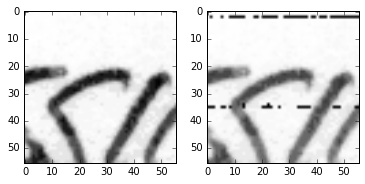

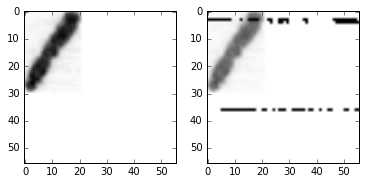

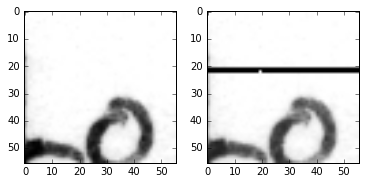

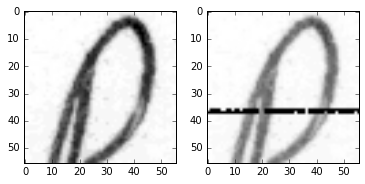

In [4]:
import matplotlib.pylab as plt
%matplotlib inline
for i in xrange(4):
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.imshow(Y[i], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(X[i], cmap='gray')

### Define the Neural Network

In [ ]:
from noisenet import basic_model, conv2_model
model = conv2_model()

Compiling model
Finished compilation


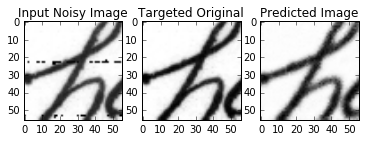

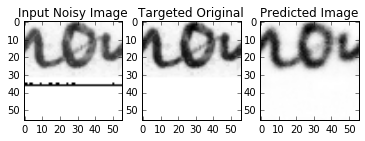

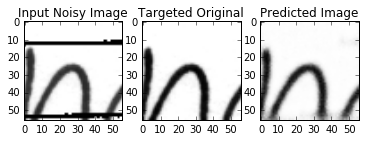

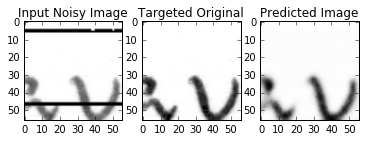

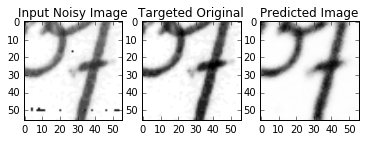

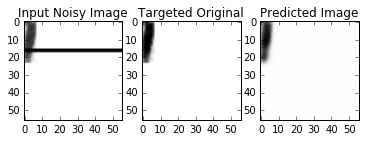

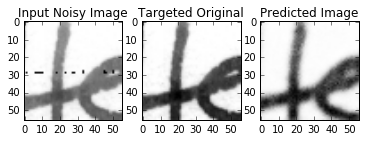

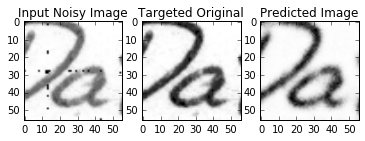

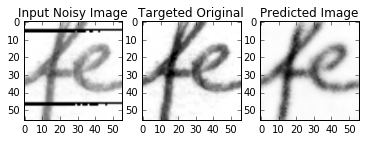

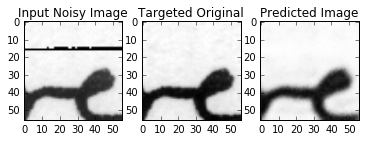

Getting batch number 65.
Adding noise to batch
Finished adding noise to batch
Reshape and preprocessed to scale between 0 and 1
Epoch 1/1
19776/32000 [=================>............] - ETA: 22s - loss: 0.0021 - acc: 0.0388

KeyboardInterrupt: 

In [9]:
import sys
from IPython.display import clear_output


for batch_iter in xrange(iterations):
    
    print "Getting batch number "+str(batch_iter)+"."
    sys.stdout.flush()
    (X_image, Y_train) = mini_m.get_batch(load_size)
    print "Adding noise to batch"
    sys.stdout.flush()
    print "Finished adding noise to batch"
    sys.stdout.flush()
        
    X_noise = noise_m.add_noise_batch(X_image, rng=rng, shingle_dim=shingle_dim)
    X_noise = 1.0 - X_noise/255.0    
    X_image = X_image.reshape( (load_size, np.prod(X_image.shape[1:])))
    X_image = 1.0 - X_image/255.0
    X_noise = np.expand_dims(X_noise, 1)
    print "Reshape and preprocessed to scale between 0 and 1"
    
    # Replace the first noisy image

    model.fit(X_noise, X_image, batch_size=batch_size, nb_epoch=1, show_accuracy=True, verbose=1) #, validation_data=(X_test, Y_test))
    
    X_example = model.predict( X_noise[:10] )
    X_example = X_example.reshape( (10,)+X_noise.shape[2:] )

    clear_output()
    for i, exim in enumerate(X_example):
        plt.subplots(1,3)
        plt.subplot(1,3,3)
        plt.imshow(1.0-X_example[i], cmap='gray')
        plt.title('Predicted Image')
        plt.subplot(1,3,2)
        plt.imshow(1.0-X_image[i].reshape(X_noise.shape[2:]), cmap='gray')
        plt.title('Targeted Original')
        plt.subplot(1,3,1)
        plt.imshow(1.0-X_noise[i][0], cmap='gray')
        plt.title('Input Noisy Image')
    plt.show()
    
    if (batch_iter % 25) == 0:
        model.save_weights('conv2_linet.hdf5', overwrite=True)

In [10]:
print X_image.shape
X_noise = X_noise.reshape( (load_size, np.prod(X_noise.shape[1:])))
print X_noise.reshape((load_size, np.prod(X_noise.shape[1:])))
# model.save_weights('linet.hdf5')
model.save_weights('conv2_linet.hdf5', overwrite=True)

(32000, 3136)
[[ 0.01568627  0.01568627  0.01568627 ...,  0.49411765  0.58039216
   0.64313725]
 [ 0.39607843  0.44313725  0.3372549  ...,  0.08627451  0.11372549
   0.16078431]
 [ 0.10588235  0.32156863  0.50980392 ...,  0.          0.          0.        ]
 ..., 
 [ 0.66666667  0.32941176  0.08235294 ...,  1.          1.          1.        ]
 [ 0.04313725  0.02352941  0.02352941 ...,  0.01568627  0.01568627
   0.01568627]
 [ 0.02352941  0.02745098  0.04705882 ...,  0.04313725  0.03921569
   0.05882353]]
[WARNING] conv2_linet.hdf5 already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!


In [ ]:
f = h5py.File('/fileserver/iam/iam-binary/iam_author_lines_bin.hdf5','r')
print f['001']['a01-000x-00'].value
plt.imshow(f['001']['a01-000x-00'])